In [96]:
import pandas as pd

from utils import get_data, get_temperature_data
from preprocessing import select_df_columns, df_interpolate_and_dropna
from models import train_test_split, build_LSTM_model, get_Xy_generator, evaluate_model, get_model_predictions

from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()

from warnings import filterwarnings
filterwarnings("ignore")

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (15, 10)  # Change the default figure size


In [2]:
%%time
df , df_raw = get_data('./data')
df_temp = get_temperature_data("./data/temperature_brescia.json")
df = df_temp.merge(df, how='outer', left_index=True, right_index=True)

Wall time: 34.3 s


In [3]:
%%time
df_prep = df.pipe(select_df_columns, ["ET_rete (potenza_termica_oraria)"])\
    .pipe(df_interpolate_and_dropna)

Wall time: 32 ms


In [4]:
%%time
train, test = train_test_split(df_prep, 2019)

train = ssc.fit_transform(train)
test = ssc.transform(test)

X_train, y_train = get_Xy_generator(train)
X_test, y_test = get_Xy_generator(test)

model = build_LSTM_model()
model.fit(X_train, y_train, epochs=5, validation_split=0.2)

y_pred = model.predict(X_test)

Epoch 1/5
1314/1314 [==============================] - 26s 18ms/step - loss: 0.0816 - val_loss: 0.0146
Epoch 2/5
1314/1314 [==============================] - 29s 22ms/step - loss: 0.0167 - val_loss: 0.0136
Epoch 3/5
1314/1314 [==============================] - 24s 18ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 4/5
1314/1314 [==============================] - 25s 19ms/step - loss: 0.0123 - val_loss: 0.0166
Epoch 5/5
1314/1314 [==============================] - 36s 27ms/step - loss: 0.0117 - val_loss: 0.0129
Wall time: 2min 27s


In [93]:
X_train.shape

(52560, 24, 1)

In [5]:
y_test = ssc.inverse_transform(y_test.reshape(-1,1))
y_pred = ssc.inverse_transform(y_pred.reshape(-1,1))

In [6]:
%%time
evaluate_model(y_test, y_pred)

mse = 51.705390018996766
mape = 3.0576546415759713
r2_score = 0.9923130520571529
Wall time: 4 ms


In [7]:
model.evaluate(X_test, ssc.transform(y_test.reshape(-1,1)))

528/528 [==============================] - 7s 12ms/step - loss: 0.0036


0.003635821398347616

In [8]:
now = datetime.utcnow().strftime("%Y%m%d%H%M")
model.save(f'models/{now}_LSTM1.h5')

In [55]:
y_pred

array([[182.07271 ],
       [134.35126 ],
       [153.25778 ],
       ...,
       [ 42.570248],
       [ 42.570248],
       [ 42.570248]], dtype=float32)

In [56]:
y_test

array([[153.33528133],
       [153.87402533],
       [151.36477247],
       ...,
       [ 43.71148685],
       [ 43.71148685],
       [ 43.71148685]])

#############################################################################################################

In [9]:
import numpy as np

In [38]:
len(true)

1345

In [70]:
train.shape, test.shape

((52584, 1), (16920, 1))

In [71]:
len(test)

16920

In [72]:
train[-24:].reshape((1, 24, 1))

array([[[0.7030609 ],
        [0.68999897],
        [0.66584403],
        [0.69096836],
        [1.00077849],
        [1.50240679],
        [2.25889645],
        [2.36021017],
        [2.18585728],
        [2.08899696],
        [1.99917411],
        [1.92564206],
        [1.79876676],
        [1.64951625],
        [1.60699164],
        [1.61455983],
        [1.75052294],
        [1.98915526],
        [1.99056487],
        [1.82457262],
        [1.64552797],
        [1.41310561],
        [1.06216706],
        [0.7291667 ]]])

In [73]:
np.append(arr=train[-24:].reshape((1, 24, 1))[:, 1:, :], values=[[[model.predict(train[-24:].reshape((1, 24, 1)))[0][0]]]], axis=1)

array([[[0.68999897],
        [0.66584403],
        [0.69096836],
        [1.00077849],
        [1.50240679],
        [2.25889645],
        [2.36021017],
        [2.18585728],
        [2.08899696],
        [1.99917411],
        [1.92564206],
        [1.79876676],
        [1.64951625],
        [1.60699164],
        [1.61455983],
        [1.75052294],
        [1.98915526],
        [1.99056487],
        [1.82457262],
        [1.64552797],
        [1.41310561],
        [1.06216706],
        [0.7291667 ],
        [0.47820273]]])

In [74]:
model.predict(train[-24:].reshape((1, 24, 1)))[0][0]

0.47820273

In [75]:
%%time
l2hat = get_model_predictions(train, test, model)

Wall time: 11min 16s


In [27]:
# l2hat_hat = []
# for i in l2hat:
#     l2hat_hat.append(i[0])

In [81]:
l2hat_hat = ssc.inverse_transform(l2hat)

In [82]:
ssc.inverse_transform(test)[:10]

array([[212.8346221 ],
       [214.36125175],
       [212.2325999 ],
       [209.98164047],
       [234.84462518],
       [286.89011753],
       [400.83020762],
       [392.74915553],
       [378.00535153],
       [353.10357092]])

In [83]:
df_test = df[["ET_rete (potenza_termica_oraria)"]].loc["2020":].interpolate()

In [84]:
df_test["predictions"] = l2hat_hat

In [85]:
evaluate_model(df_test["ET_rete (potenza_termica_oraria)"], df_test["predictions"])

mse = 90005.6007669079
mape = 522.6059743188583
r2_score = -12.261540084353525


In [89]:
evaluate_model(ssc.inverse_transform(test), l2hat_hat)

mse = 90005.6007669079
mape = 521.6274592983596
r2_score = -12.261540084353525


In [90]:
evaluate_model(test, l2hat)

mse = 6.329045573637411
mape = 869.2461631887884
r2_score = -12.261539275561086


In [100]:
evaluate_model(df_test.head(24)["ET_rete (potenza_termica_oraria)"], df_test.head(24)["predictions"])

mse = 3135.359685855856
mape = 15.931940276776398
r2_score = 0.10256613967990902


In [86]:
df_test.head(48)

,ET_rete (potenza_termica_oraria),predictions
2020-01-01 00:00:00,212.834622,196.726379
2020-01-01 01:00:00,214.361252,182.441986
2020-01-01 02:00:00,212.232600,179.374664
2020-01-01 03:00:00,209.981640,187.190445
2020-01-01 04:00:00,234.844625,215.618317
2020-01-01 05:00:00,286.890118,296.433746
2020-01-01 06:00:00,400.830208,425.869446
2020-01-01 07:00:00,392.749156,442.294586
2020-01-01 08:00:00,378.005352,431.855255
2020-01-01 09:00:00,353.103571,402.181946


<AxesSubplot:>

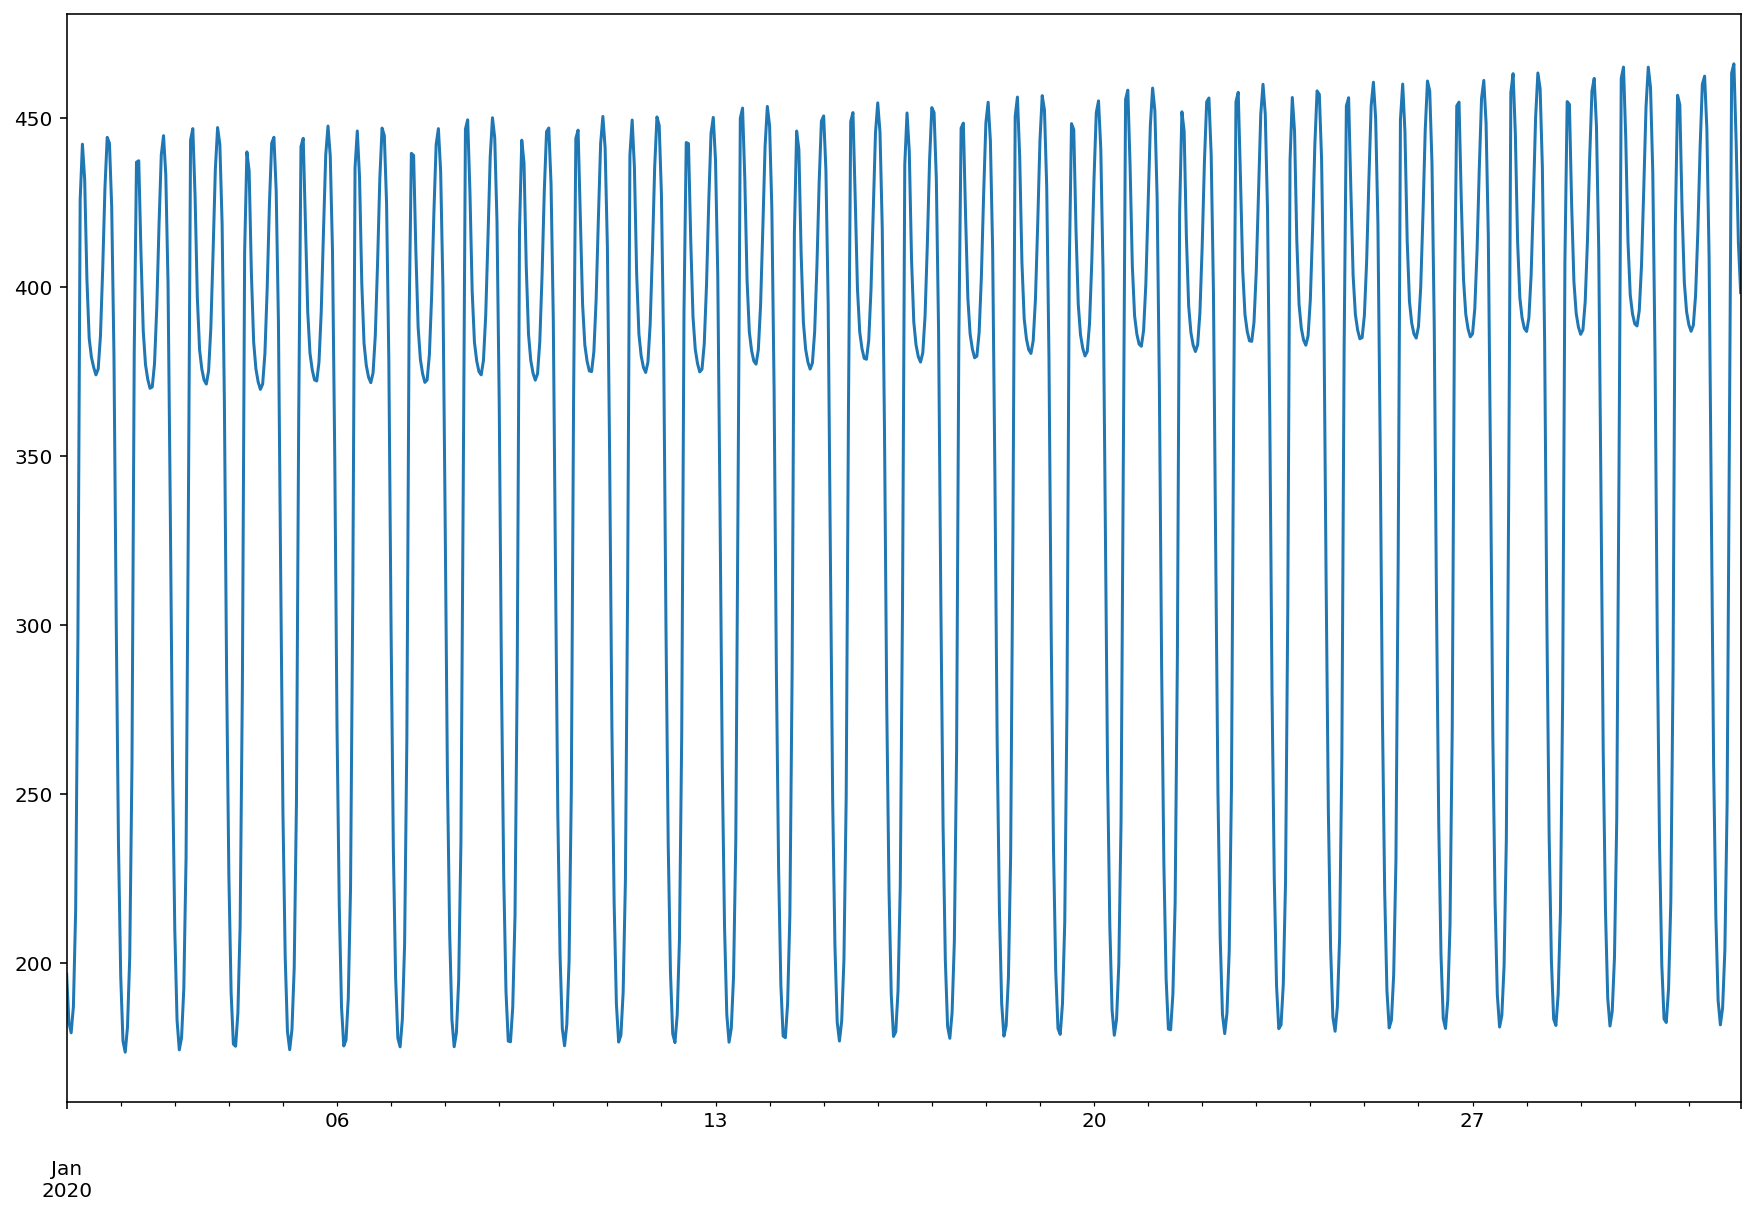

In [99]:
df_test["predictions"].loc[:"2020-01"].plot()